In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import rasterio
import torch
import numpy as np
from PIL import Image
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import compute_unary, unary_from_softmax
from scipy.stats import percentileofscore
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../models')
from unet_model import UNet
sys.path.insert(0, '../utils')
from metrics import returnCRFmask
from difference_metrics import returnPredictions, returnIou, returnCafoDiff, returnClusterDiff, returnShiftDiff

In [2]:
model = UNet(3, 2)
model.load_state_dict(torch.load('../../../saved_models/finished/model8_10_ia_data.pth'))
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model.to(device)
NUM_CLASSES = 2

In [3]:
with open('../null/iou_null.p', 'rb') as f:
    iou_null = pickle.load(f)
    
with open('../null/pixel_diff_null.p', 'rb') as f:
    pixel_diff = pickle.load(f)
    
with open('../null/cluster_diff_null.p', 'rb') as f:
    cluster_diff = pickle.load(f)
    
with open('../null/shift_diff_null.p', 'rb') as f:
    shift_diff = pickle.load(f)

Text(0.5, 1.0, 'Mask Shift Difference')

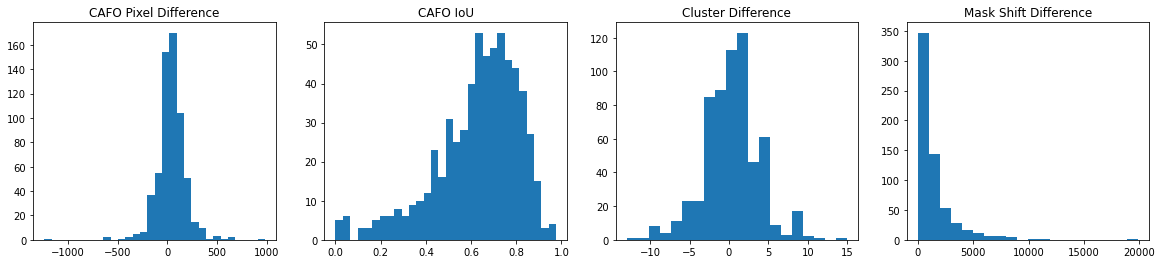

In [4]:
f = plt.figure(figsize=(20,4))
a1 = f.add_subplot(1, 4, 1)
plt.hist(pixel_diff, bins=30)
plt.title("CAFO Pixel Difference")
a2 = f.add_subplot(1, 4, 2)
plt.hist(iou_null, bins=30)
plt.title("CAFO IoU")
a3 = f.add_subplot(1, 4, 3)
plt.hist(cluster_diff, bins=20)
plt.title("Cluster Difference")
a4 = f.add_subplot(1, 4, 4)
plt.hist(shift_diff, bins=20)
plt.title("Mask Shift Difference")

In [5]:
dir_2019 = '../../../../../datadrive/data/raw/planet_images_il-2019-07/'
dir_2020 = '../../../../../datadrive/data/raw/planet_images_il-2020-07/'
image_num_list = ['035', '045', '048', '081', '160', '175', '177', '227', '050', '153', 
                  '028', '135', '130', '102', '137', '165', '080', '032', 
                  '152', '180', '057'] #171, 149 is a line

In [6]:
kwarg_dict = {'CAFO Shed': {'cmap':'hot', 'alpha': 0.0}, 
                  'Lagoon': {'cmap':'cool', 'alpha': 0.5},
                  'BACKGROUND': {'cmap':'prism', 'alpha': 0.5}}

In [7]:
def returnPredSet(filepath, model):        
    with rasterio.open(filepath) as src:
        b, g, r, n = src.read()
    rgb = np.stack((r,g,b), axis=0)   
    im = Image.fromarray((np.rollaxis(rgb/rgb.max(), 0, 3)*255).astype(np.uint8))    
    im = ToTensor()(im)
    with torch.no_grad():
        output = model((im.unsqueeze(0)))#.to(device))    
    _, predictions = torch.max(output, 1)
    predictions_one_hot = torch.nn.functional.one_hot(predictions, num_classes=NUM_CLASSES).permute(0, 3, 1, 2)
    crf_mask = returnCRFmask(torch.Tensor(rgb/rgb.max()), output, NUM_CLASSES)
    
    return im, predictions, predictions_one_hot, crf_mask

(-0.5, 340.5, 344.5, -0.5)

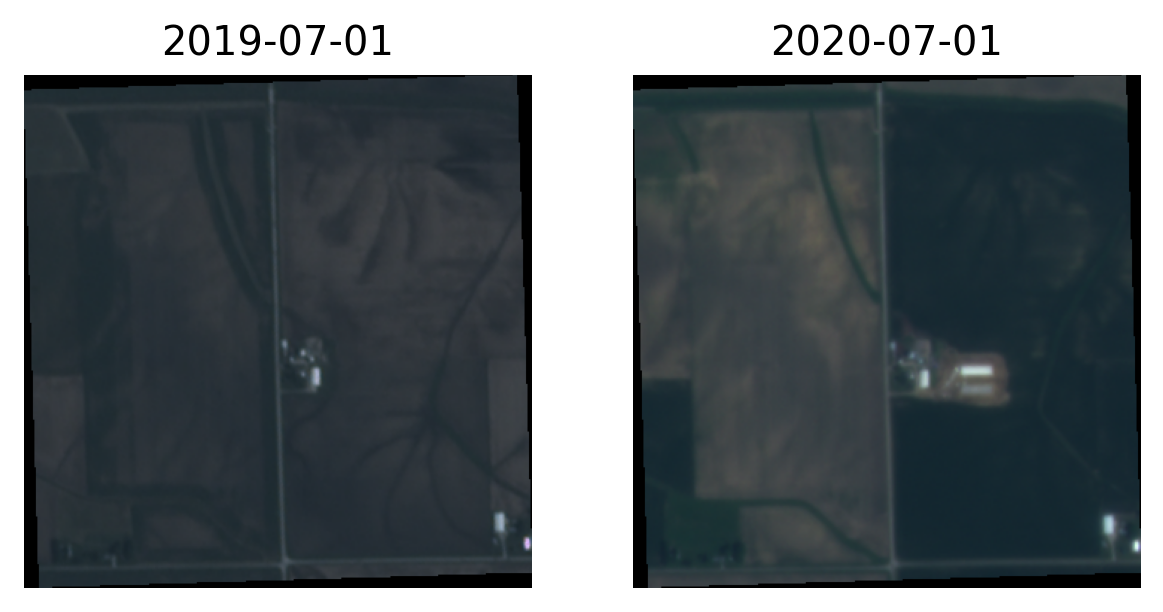

In [8]:
number = image_num_list[7]
im2019 = dir_2019 + "planet_loc_"+number+"-date_2019-07-01.tif"
im2020 = dir_2020 + "planet_loc_"+number+"-date_2020-07-01.tif"
im1, predictions1, predictions_one_hot1, crf_mask1 = returnPredSet(im2019, model)
im2, predictions2, predictions_one_hot2, crf_mask2 = returnPredSet(im2020, model)
        

f = plt.figure(dpi=240) 
a1 = f.add_subplot(1, 2, 1)
plt.imshow(im1.permute(1, 2, 0).cpu().numpy())    
a1.set_title('2019-07-01')
plt.axis('off')
a2 = f.add_subplot(1, 2, 2)
plt.imshow(im2.permute(1, 2, 0).cpu().numpy())    
a2.set_title('2020-07-01')
plt.axis('off')

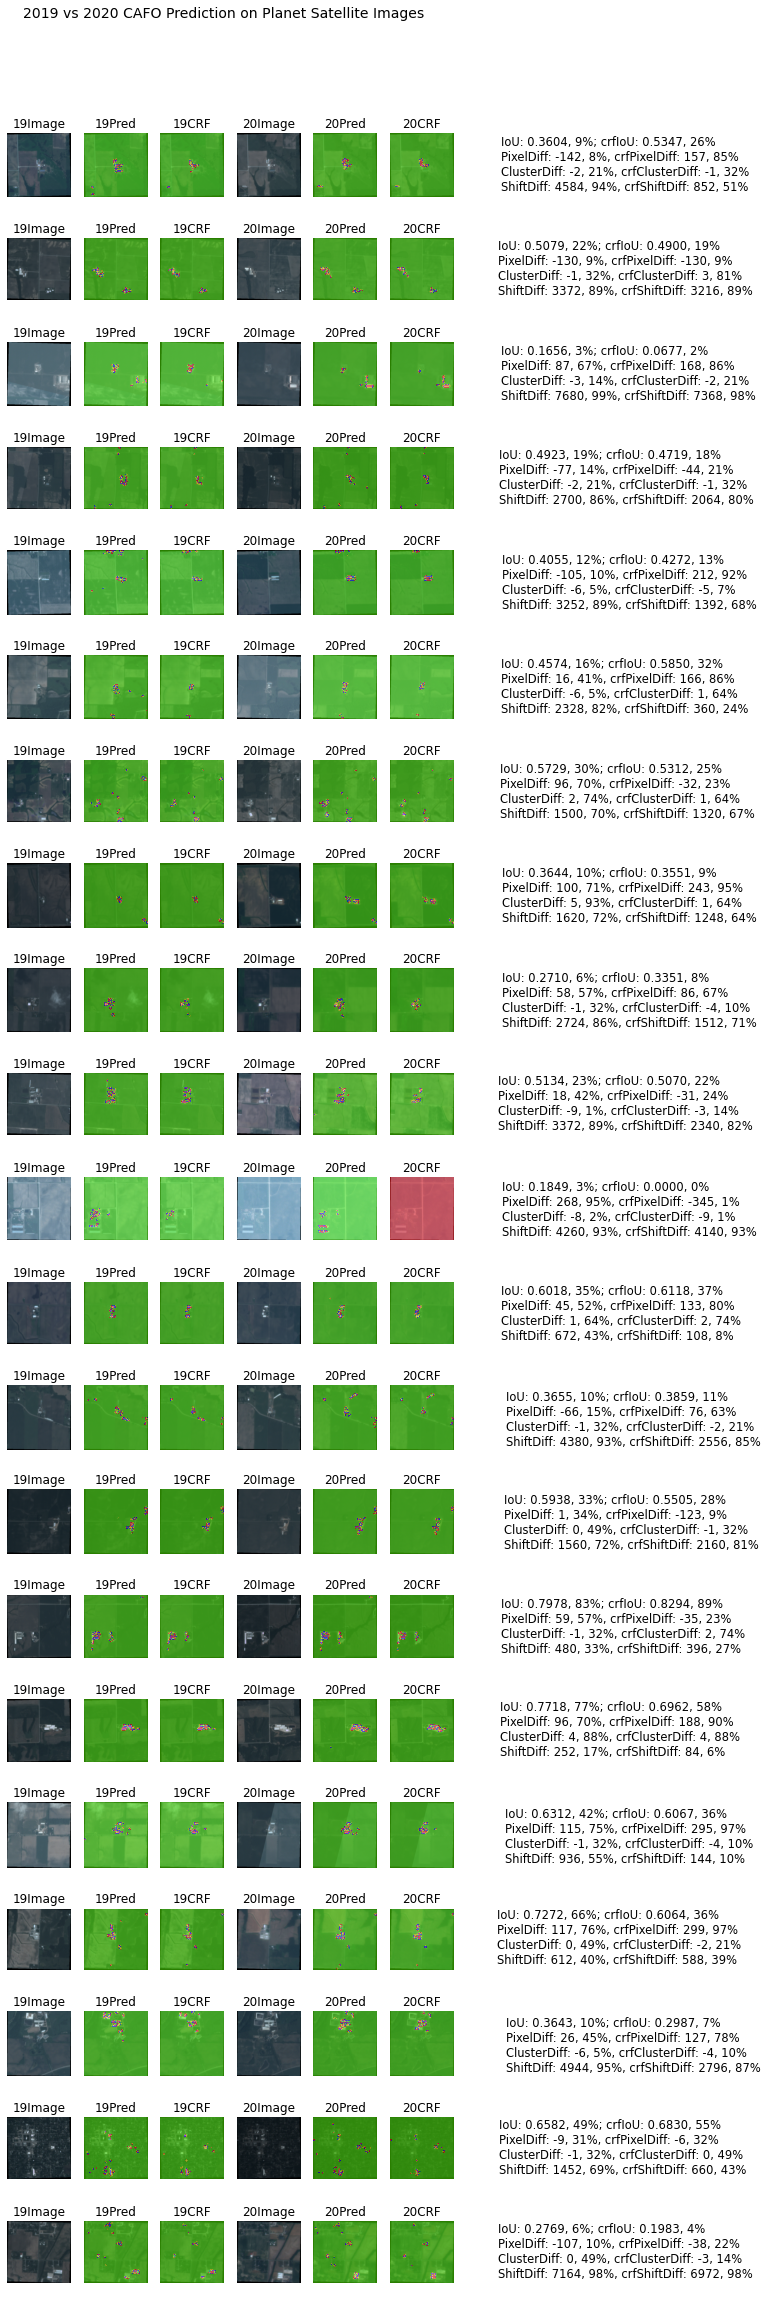

In [9]:
f = plt.figure(figsize=(8,40)) 
f.suptitle("2019 vs 2020 CAFO Prediction on Planet Satellite Images", y = .92, fontsize=14)
for i, number in enumerate(image_num_list):
    im2019 = dir_2019 + "planet_loc_"+number+"-date_2019-07-01.tif"
    im2020 = dir_2020 + "planet_loc_"+number+"-date_2020-07-01.tif"
    
    im1, predictions1, predictions_one_hot1, crf_mask1 = returnPredSet(im2019, model)
    im2, predictions2, predictions_one_hot2, crf_mask2 = returnPredSet(im2020, model)
        
    #Calculating metrics
    crf_mask_ten1 = crf_mask1[1].unsqueeze(0)
    crf_mask_ten2 = crf_mask2[1].unsqueeze(0)
    
    predictions1 = predictions1.cpu()
    predictions2 = predictions2.cpu()

    iou = returnIou(predictions1, predictions2)
    iou_percentile = percentileofscore(iou_null, iou)

    pixeld = returnCafoDiff(predictions1, predictions2)
    pixeld_percentile = percentileofscore(pixel_diff, pixeld)

    clusterd = returnClusterDiff(predictions1, predictions2)
    clusterd_percentile = percentileofscore(cluster_diff, clusterd)

    shiftd = returnShiftDiff(predictions1, predictions2)
    shiftd_percentile = percentileofscore(shift_diff, shiftd)

    ###

    ioucrf = returnIou(crf_mask_ten1, crf_mask_ten2)
    ioucrf_percentile = percentileofscore(iou_null, ioucrf)

    pixeldcrf = returnCafoDiff(crf_mask_ten1, crf_mask_ten2)
    pixeldcrf_percentile = percentileofscore(pixel_diff, pixeldcrf)

    clusterdcrf = returnClusterDiff(crf_mask_ten1, crf_mask_ten2)
    clusterdcrf_percentile = percentileofscore(cluster_diff, clusterdcrf)

    shiftdcrf = returnShiftDiff(crf_mask_ten1, crf_mask_ten2)
    shiftdcrf_percentile = percentileofscore(shift_diff, shiftdcrf)
    
    textstr = (f'IoU: {iou:.4f}, {iou_percentile:.0f}%; crfIoU: {ioucrf:.4f}, {ioucrf_percentile:.0f}%\n'
              f'PixelDiff: {pixeld:.0f}, {pixeld_percentile:.0f}%, crfPixelDiff: {pixeldcrf:.0f}, {pixeldcrf_percentile:.0f}%\n'
              f'ClusterDiff: {clusterd:.0f}, {clusterd_percentile:.0f}%, crfClusterDiff: {clusterdcrf:.0f}, {clusterdcrf_percentile:.0f}%\n'
              f'ShiftDiff: {shiftd:.0f}, {shiftd_percentile:.0f}%, crfShiftDiff: {shiftdcrf:.0f}, {shiftdcrf_percentile:.0f}%\n')
    
    # BEFORE IMAGE
    
    a1 = f.add_subplot(len(image_num_list), 6, 6*i + 1)
    plt.imshow(im1.permute(1, 2, 0).cpu().numpy())    
    a1.set_title('19Image')
    plt.axis('off')

    a2 = f.add_subplot(len(image_num_list), 6, 6*i + 2)
    plt.imshow(im1.permute(1, 2, 0).cpu().numpy())
    plt.imshow(predictions_one_hot1[0][0].cpu().numpy(), **kwarg_dict['BACKGROUND'])    
    plt.imshow(predictions_one_hot1[0][1].cpu().numpy(), **kwarg_dict['CAFO Shed'])        
    a2.set_title('19Pred')
    plt.axis('off')    

    a3 = f.add_subplot(len(image_num_list), 6, 6*i + 3)    
    plt.imshow(im1.permute(1, 2, 0).cpu().numpy())
    plt.imshow(crf_mask1[0].numpy(), **kwarg_dict['BACKGROUND'])
    plt.imshow(crf_mask1[1].numpy(), **kwarg_dict['CAFO Shed'])    
    a3.set_title('19CRF')
    plt.axis('off')    

    # AFTER IMAGE

    a4 = f.add_subplot(len(image_num_list), 6, 6*i + 4)
    plt.imshow(im2.permute(1, 2, 0).cpu().numpy())    
    plt.axis('off')
    a4.set_title('20Image')

    a5 = f.add_subplot(len(image_num_list), 6, 6*i + 5)
    plt.imshow(im2.permute(1, 2, 0).cpu().numpy())
    plt.imshow(predictions_one_hot2[0][0].cpu().numpy(), **kwarg_dict['BACKGROUND'])    
    plt.imshow(predictions_one_hot2[0][1].cpu().numpy(), **kwarg_dict['CAFO Shed'])        
    a5.set_title('20Pred')
    plt.axis('off')

    a6 = f.add_subplot(len(image_num_list), 6, 6*i + 6)    
    plt.imshow(im2.permute(1, 2, 0).cpu().numpy())
    plt.imshow(crf_mask2[0].numpy(), **kwarg_dict['BACKGROUND'])
    plt.imshow(crf_mask2[1].numpy(), **kwarg_dict['CAFO Shed'])    
    a6.set_title('20CRF')
    plt.axis('off')    
    a6.text(600, 390, textstr, fontsize=11.5)
    
plt.show()

In [10]:
#lower iou indicative of more change
#Pixel diff relatively noisy so not that importnat
#Cluster diff, higher means more change. Fairly noisy
#Shift diff, higher means more change

In [11]:
#idxs = [1, 3, 4, 5, 6, 8, 13, 17, 20]
idxs = [1, 4, 13, 17]
new_image_num_list = [image_num_list[idx] for idx in idxs] 

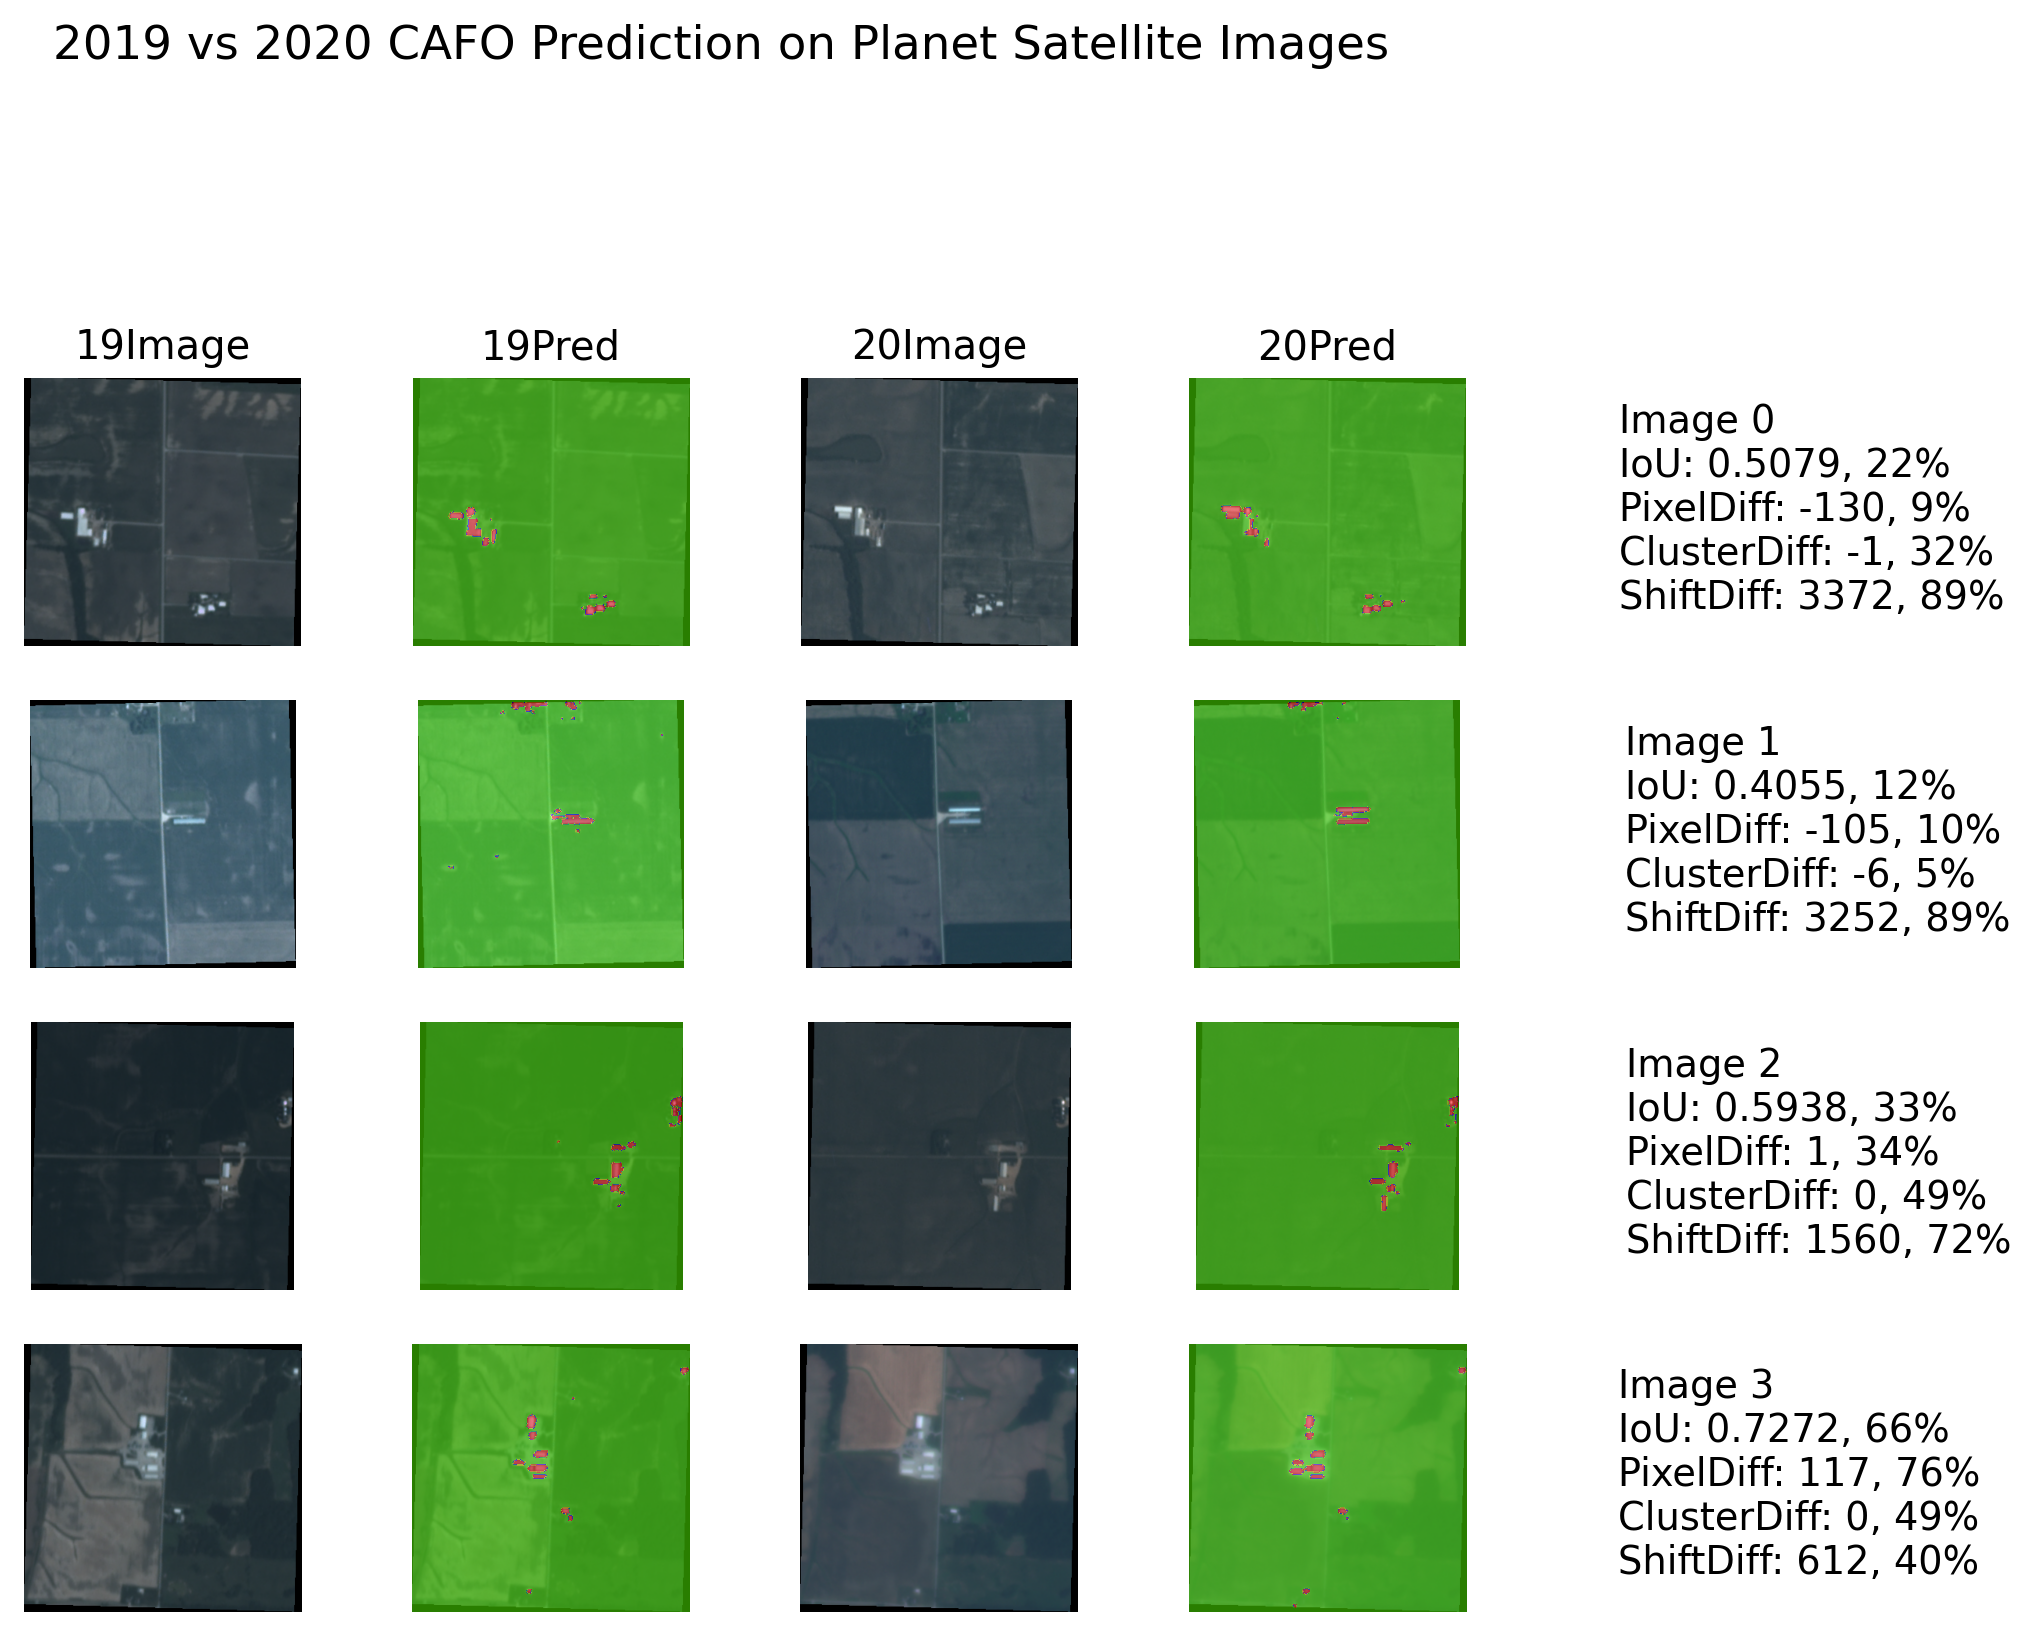

In [12]:
f = plt.figure(figsize=(8,37), dpi=240) 
f.suptitle("2019 vs 2020 CAFO Prediction on Planet Satellite Images", y = .92, fontsize=14)
for i, number in enumerate(new_image_num_list):
    im2019 = dir_2019 + "planet_loc_"+number+"-date_2019-07-01.tif"
    im2020 = dir_2020 + "planet_loc_"+number+"-date_2020-07-01.tif"
    
    im1, predictions1, predictions_one_hot1, crf_mask1 = returnPredSet(im2019, model)
    im2, predictions2, predictions_one_hot2, crf_mask2 = returnPredSet(im2020, model)
        
    #Calculating metrics
    crf_mask_ten1 = crf_mask1[1].unsqueeze(0)
    crf_mask_ten2 = crf_mask2[1].unsqueeze(0)
    
    predictions1 = predictions1.cpu()
    predictions2 = predictions2.cpu()

    iou = returnIou(predictions1, predictions2)
    iou_percentile = percentileofscore(iou_null, iou)

    pixeld = returnCafoDiff(predictions1, predictions2)
    pixeld_percentile = percentileofscore(pixel_diff, pixeld)

    clusterd = returnClusterDiff(predictions1, predictions2)
    clusterd_percentile = percentileofscore(cluster_diff, clusterd)

    shiftd = returnShiftDiff(predictions1, predictions2)
    shiftd_percentile = percentileofscore(shift_diff, shiftd)

    ###

    ioucrf = returnIou(crf_mask_ten1, crf_mask_ten2)
    ioucrf_percentile = percentileofscore(iou_null, ioucrf)

    pixeldcrf = returnCafoDiff(crf_mask_ten1, crf_mask_ten2)
    pixeldcrf_percentile = percentileofscore(pixel_diff, pixeldcrf)

    clusterdcrf = returnClusterDiff(crf_mask_ten1, crf_mask_ten2)
    clusterdcrf_percentile = percentileofscore(cluster_diff, clusterdcrf)

    shiftdcrf = returnShiftDiff(crf_mask_ten1, crf_mask_ten2)
    shiftdcrf_percentile = percentileofscore(shift_diff, shiftdcrf)
    
    textstr = ( f'Image {i}\n'
              f'IoU: {iou:.4f}, {iou_percentile:.0f}%\n'
              f'PixelDiff: {pixeld:.0f}, {pixeld_percentile:.0f}%\n'
              f'ClusterDiff: {clusterd:.0f}, {clusterd_percentile:.0f}%\n'
              f'ShiftDiff: {shiftd:.0f}, {shiftd_percentile:.0f}%\n')
    
    # BEFORE IMAGE
    
    a1 = f.add_subplot(len(image_num_list), 4, 4*i + 1)
    plt.imshow(im1.permute(1, 2, 0).cpu().numpy())    
    
    plt.axis('off')

    a2 = f.add_subplot(len(image_num_list), 4, 4*i + 2)
    plt.imshow(im1.permute(1, 2, 0).cpu().numpy())
    plt.imshow(predictions_one_hot1[0][0].cpu().numpy(), **kwarg_dict['BACKGROUND'])    
    plt.imshow(predictions_one_hot1[0][1].cpu().numpy(), **kwarg_dict['CAFO Shed'])        
    
    plt.axis('off')    

    # AFTER IMAGE

    a3 = f.add_subplot(len(image_num_list), 4, 4*i + 3)
    plt.imshow(im2.permute(1, 2, 0).cpu().numpy())    
    plt.axis('off')
    

    a4 = f.add_subplot(len(image_num_list), 4, 4*i + 4)
    plt.imshow(im2.permute(1, 2, 0).cpu().numpy())
    plt.imshow(predictions_one_hot2[0][0].cpu().numpy(), **kwarg_dict['BACKGROUND'])    
    plt.imshow(predictions_one_hot2[0][1].cpu().numpy(), **kwarg_dict['CAFO Shed'])        
    
    plt.axis('off')
    
    if i == 0:
        a1.set_title('19Image')
        a2.set_title('19Pred')
        a3.set_title('20Image')
        a4.set_title('20Pred')
        
    a4.text(550, 350, textstr, fontsize=11.5)
    
plt.show()